# Business Goal
## Create a short-term temperature forecast for weather station Berlin-Tempelhof

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 

#from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Set the figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

## Load the data

prepared .csv without header manually

info regarding original data: 
- 01-06 SOUID: Source identifier
- 08-15 DATE : Date YYYYMMDD
- 17-21 TG   : mean temperature in 0.1 &#176;C
- 23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

In [ ]:
df_tempelhof = pd.read_csv('data/TG_STAID002759_prepared.csv', parse_dates=True, index_col=1, sep = ',')
df_tempelhof.rename(columns = {' SOUID':'Source Identifier', '   TG':'Mean Temp. in 0.1 °C', ' Q_TG':'Quality Code'}, inplace=True)

df_Q_TG1 = df_tempelhof.loc[df_tempelhof['Quality Code']==1]
df_Q_TG9 = df_tempelhof.loc[df_tempelhof['Quality Code']==9]
print(df_Q_TG1.shape, df_Q_TG9.shape)

In [ ]:
df_tempelhof.loc[df_tempelhof['Quality Code']==9].tail()

In [ ]:
df_tempelhof.loc[df_tempelhof['Quality Code']==1]

## Clean the data

checked above that there is exactly one value with quality code  = 1 for Tempelhof on Jan 21, 1947
last occurrence of quality code Nov 5, 1945

Therefore cut off data up to and including 1947-01-21

In [55]:
df = df_tempelhof.truncate(before='1947-01-22')
df.head(3)

,Source Identifier,Mean Temp. in 0.1 °C,Quality Code
DATE,,,
1947-01-22,128124,-28,0
1947-01-23,128124,-38,0
1947-01-24,128124,-45,0


In [56]:
df = df.drop(columns = {'Source Identifier', 'Quality Code'})
df.head()

,Mean Temp. in 0.1 °C
DATE,
1947-01-22,-28
1947-01-23,-38
1947-01-24,-45
1947-01-25,-53
1947-01-26,-87


In [57]:
df['Mean Temp. in 0.1 °C'] = df['Mean Temp. in 0.1 °C']*0.1
df.rename(columns = {'Mean Temp. in 0.1 °C':'MeanTempC'}, inplace=True)
df

,MeanTempC
DATE,
1947-01-22,-2.8
1947-01-23,-3.8
1947-01-24,-4.5
1947-01-25,-5.3
1947-01-26,-8.7
...,...
2020-10-27,10.0
2020-10-28,10.5
2020-10-29,10.4


#### Plot filtered data

In [58]:
def plot_temps(df, title='Mean temperature in °C in Berlin-Tempelhof', ylim=True):

    df.plot()
    plt.title(title)
    plt.ylabel('Temperature in °C')
    plt.show()

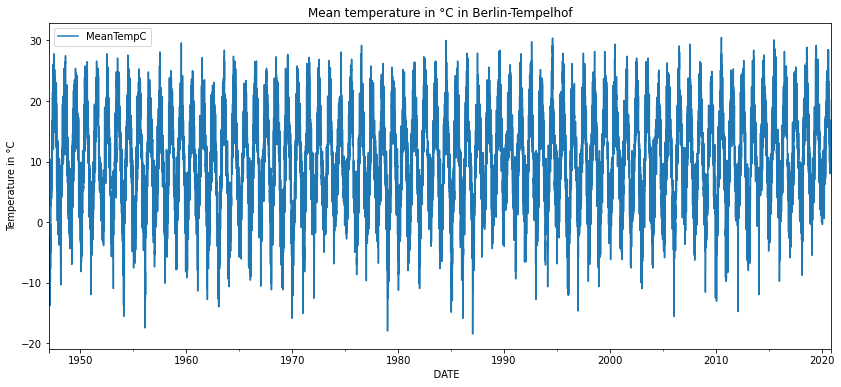

In [59]:
plot_temps(df)

## Extract the timestep and the seasonal dummies for the whole dataset

In [60]:
df['month'] = df.index.month
df['day'] = df.index.day
df.head()

,MeanTempC,month,day
DATE,,,
1947-01-22,-2.8,1,22
1947-01-23,-3.8,1,23
1947-01-24,-4.5,1,24
1947-01-25,-5.3,1,25
1947-01-26,-8.7,1,26


In [61]:
df['timestep'] = list(range(len(df)))
df.head()

,MeanTempC,month,day,timestep
DATE,,,,
1947-01-22,-2.8,1,22,0
1947-01-23,-3.8,1,23,1
1947-01-24,-4.5,1,24,2
1947-01-25,-5.3,1,25,3
1947-01-26,-8.7,1,26,4


In [62]:
#one hot encodes the month
seasonal_dummies = pd.get_dummies(df.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(df.index)
df = df.join(seasonal_dummies)
df.head(3)

,MeanTempC,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,
1947-01-22,-2.8,1,22,0,0,0,0,0,0,0,0,0,0,0,0
1947-01-23,-3.8,1,23,1,0,0,0,0,0,0,0,0,0,0,0
1947-01-24,-4.5,1,24,2,0,0,0,0,0,0,0,0,0,0,0


## Train-Test-split

one data point per day, cut off the last year = 365 days for test

In [63]:
df_train = df[:-365]
df_test = df[-365:]
df_train.head()

,MeanTempC,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,
1947-01-22,-2.8,1,22,0,0,0,0,0,0,0,0,0,0,0,0
1947-01-23,-3.8,1,23,1,0,0,0,0,0,0,0,0,0,0,0
1947-01-24,-4.5,1,24,2,0,0,0,0,0,0,0,0,0,0,0
1947-01-25,-5.3,1,25,3,0,0,0,0,0,0,0,0,0,0,0
1947-01-26,-8.7,1,26,4,0,0,0,0,0,0,0,0,0,0,0


In [64]:
X_train = df_train.drop(columns = ['MeanTempC', 'month', 'day'])
X_test = df_test.drop(columns = ['MeanTempC', 'month', 'day'])
y_train = df_train['MeanTempC']
y_test = df_test['MeanTempC']
#X_train
#X_test
#y_train
#y_test

# Feature Engineering

## Model the trend_seasonal model using the training data

In [65]:
m = LinearRegression()
m.fit(X_train,y_train)

LinearRegression()

In [66]:
df_train['trend_seasonal'] = m.predict(X_train)

In [67]:
df2train = df_train.copy()
df2train['trend_seasonal'] = m.predict(X_train)
df_train = df2train
df_train.head()

,MeanTempC,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
DATE,,,,,,,,,,,,,,,,
1947-01-22,-2.8,1,22,0,0,0,0,0,0,0,0,0,0,0,0,-0.405558
1947-01-23,-3.8,1,23,1,0,0,0,0,0,0,0,0,0,0,0,-0.405500
1947-01-24,-4.5,1,24,2,0,0,0,0,0,0,0,0,0,0,0,-0.405442
1947-01-25,-5.3,1,25,3,0,0,0,0,0,0,0,0,0,0,0,-0.405384
1947-01-26,-8.7,1,26,4,0,0,0,0,0,0,0,0,0,0,0,-0.405325


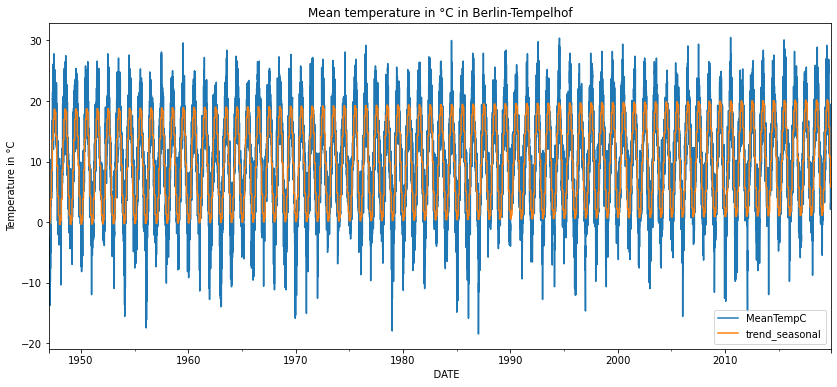

In [68]:
plot_temps(df_train[['MeanTempC', 'trend_seasonal']])

## Extract the remainder

In [69]:
df3train = df_train.copy()
df3train['remainder'] = df_train['MeanTempC']-df_train['trend_seasonal']
df_train = df3train
df_train.head()

,MeanTempC,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder
DATE,,,,,,,,,,,,,,,,,
1947-01-22,-2.8,1,22,0,0,0,0,0,0,0,0,0,0,0,0,-0.405558,-2.394442
1947-01-23,-3.8,1,23,1,0,0,0,0,0,0,0,0,0,0,0,-0.405500,-3.394500
1947-01-24,-4.5,1,24,2,0,0,0,0,0,0,0,0,0,0,0,-0.405442,-4.094558
1947-01-25,-5.3,1,25,3,0,0,0,0,0,0,0,0,0,0,0,-0.405384,-4.894616
1947-01-26,-8.7,1,26,4,0,0,0,0,0,0,0,0,0,0,0,-0.405325,-8.294675


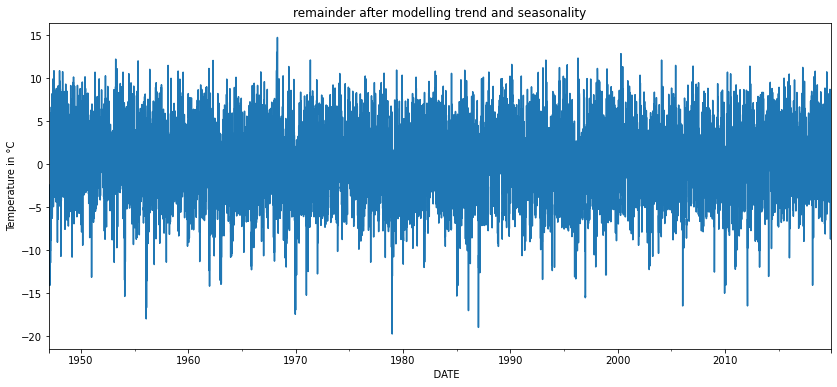

In [70]:
plot_temps(df_train['remainder'], title = 'remainder after modelling trend and seasonality', ylim = False)

In [71]:
df_train['remainder'].mean()

-3.564140848296304e-16

In [72]:
df_train['remainder'].to_csv('data/temps_train_remainder.csv')

## Inspect the remainder to decide how many lags to include

### done in TempForecasteAutoreg.ipynb

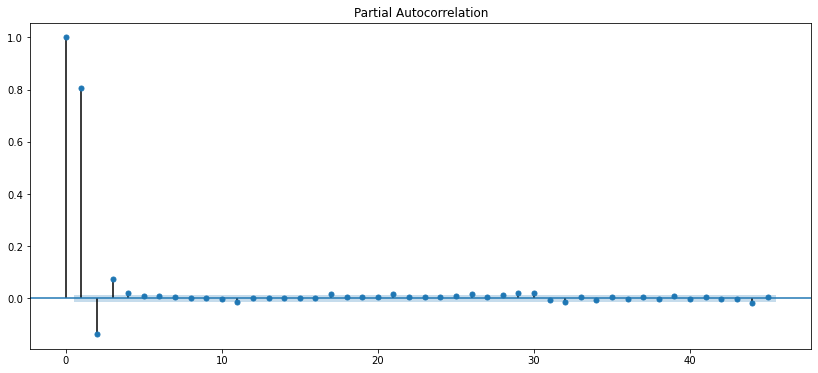

In [73]:
figx = pickle.load(  open('data/TempAutocorr.pickle',  'rb')  )

#### Include three lags to the training data

Include legs 2 and 3 possibly?

selected_order.ar_lags in Autoregression notebook gave 

array([1, 2, 3])

=> include lag1, lag2, lag3

In [74]:
df4train = df_train.copy()
df4train['lag1'] = df_train['remainder'].shift(1)
df4train['lag2'] = df_train['remainder'].shift(2)
df4train['lag3'] = df_train['remainder'].shift(3)
df4train.dropna(inplace=True)
df_train = df4train
df_train.head()

,MeanTempC,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,,,
1947-01-25,-5.3,1,25,3,0,0,0,0,0,0,0,0,0,0,0,-0.405384,-4.894616,-4.094558,-3.394500,-2.394442
1947-01-26,-8.7,1,26,4,0,0,0,0,0,0,0,0,0,0,0,-0.405325,-8.294675,-4.894616,-4.094558,-3.394500
1947-01-27,-11.3,1,27,5,0,0,0,0,0,0,0,0,0,0,0,-0.405267,-10.894733,-8.294675,-4.894616,-4.094558
1947-01-28,-10.2,1,28,6,0,0,0,0,0,0,0,0,0,0,0,-0.405209,-9.794791,-10.894733,-8.294675,-4.894616
1947-01-29,-9.4,1,29,7,0,0,0,0,0,0,0,0,0,0,0,-0.405150,-8.994850,-9.794791,-10.894733,-8.294675


In [75]:
X_full_train = df_train.drop(columns = ['MeanTempC', 'month', 'day', 'trend_seasonal','remainder'])
y_full_train = df_train['MeanTempC']
X_full_train.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,
1947-01-25,3,0,0,0,0,0,0,0,0,0,0,0,-4.094558,-3.394500,-2.394442
1947-01-26,4,0,0,0,0,0,0,0,0,0,0,0,-4.894616,-4.094558,-3.394500
1947-01-27,5,0,0,0,0,0,0,0,0,0,0,0,-8.294675,-4.894616,-4.094558
1947-01-28,6,0,0,0,0,0,0,0,0,0,0,0,-10.894733,-8.294675,-4.894616
1947-01-29,7,0,0,0,0,0,0,0,0,0,0,0,-9.794791,-10.894733,-8.294675


# Train the full model on feature engineered data

In [76]:
m_full = LinearRegression()
m_full.fit(X_full_train, y_full_train)

LinearRegression()

In [77]:
mdt_full = DecisionTreeRegressor(max_depth=10)
mdt_full.fit(X_full_train, y_full_train)

DecisionTreeRegressor(max_depth=10)

In [78]:
mrf_full = RandomForestRegressor(n_estimators = 100, random_state = 0) 
mrf_full.fit(X_full_train, y_full_train)

RandomForestRegressor(random_state=0)

In [79]:
# Create a new predictions column
df5train = df_train.copy()
df5train['predictions_full_model'] = m_full.predict(X_full_train)
df5train['predictions_full_modeldt'] = mdt_full.predict(X_full_train)
df5train['predictions_full_modelrf'] = mrf_full.predict(X_full_train)
df_train = df5train
df_train.head(3)

,MeanTempC,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,...,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full_model,predictions_full_modeldt,predictions_full_modelrf
DATE,,,,,,,,,,,,,,,,,,,,,
1947-01-25,-5.3,1,25,3,0,0,0,0,0,0,...,0,0,-0.405384,-4.894616,-4.094558,-3.394500,-2.394442,-3.649669,-1.157258,-5.204
1947-01-26,-8.7,1,26,4,0,0,0,0,0,0,...,0,0,-0.405325,-8.294675,-4.894616,-4.094558,-3.394500,-4.320907,-1.157258,-7.048
1947-01-27,-11.3,1,27,5,0,0,0,0,0,0,...,0,0,-0.405267,-10.894733,-8.294675,-4.894616,-4.094558,-7.355069,-4.742436,-9.993


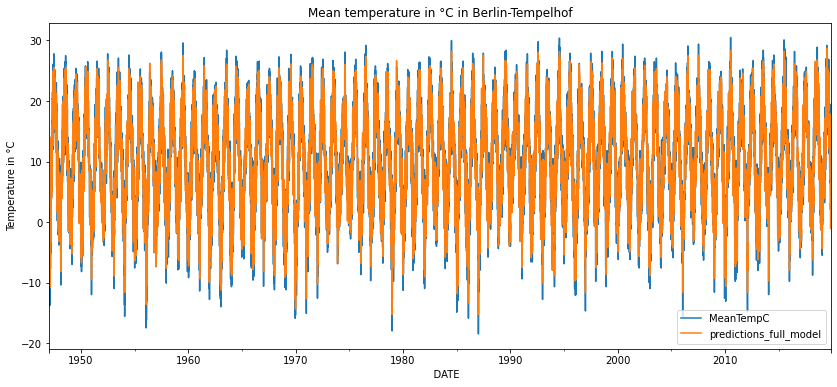

In [80]:
plot_temps(df_train[['MeanTempC', 'predictions_full_model']])

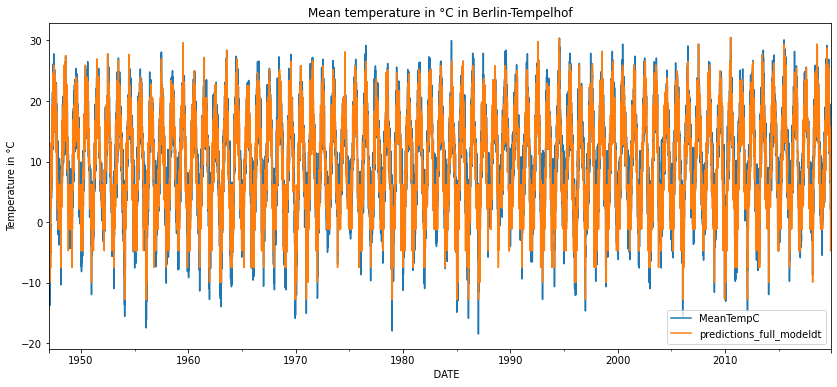

In [81]:
plot_temps(df_train[['MeanTempC', 'predictions_full_modeldt']])

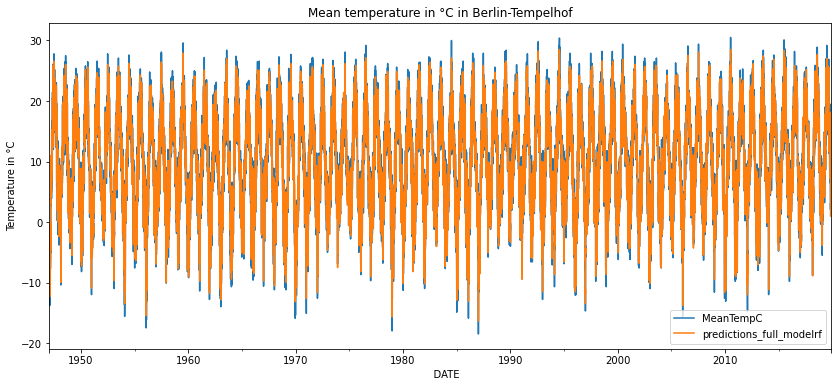

In [82]:
plot_temps(df_train[['MeanTempC', 'predictions_full_modelrf']])

In [83]:
pd.DataFrame(m_full.coef_.reshape(1,15), columns=X_full_train.columns)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3
0,0.000058,0.682681,4.147143,8.969188,13.898786,17.253931,19.00102,18.450358,14.515716,9.592525,4.636209,1.428569,0.925135,-0.203498,0.07359


## Optimize hyperparameters/cross-validation

In [84]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [85]:
# Split the training data into folds
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full_train, y_full_train)):
    print(f'The training data for the {i+1}th iteration are the observations {train_index}')
    print(f'The validation data for the {i+1}th iteration are the observations {validation_index}')
    print()


The training data for the 1th iteration are the observations [   0    1    2 ... 4431 4432 4433]
The validation data for the 1th iteration are the observations [4434 4435 4436 ... 8860 8861 8862]

The training data for the 2th iteration are the observations [   0    1    2 ... 8860 8861 8862]
The validation data for the 2th iteration are the observations [ 8863  8864  8865 ... 13289 13290 13291]

The training data for the 3th iteration are the observations [    0     1     2 ... 13289 13290 13291]
The validation data for the 3th iteration are the observations [13292 13293 13294 ... 17718 17719 17720]

The training data for the 4th iteration are the observations [    0     1     2 ... 17718 17719 17720]
The validation data for the 4th iteration are the observations [17721 17722 17723 ... 22147 22148 22149]

The training data for the 5th iteration are the observations [    0     1     2 ... 22147 22148 22149]
The validation data for the 5th iteration are the observations [22150 22151 221

In [86]:
# Create the time series split
time_series_split = ts_split.split(X_full_train, y_full_train) 

In [87]:
# Do the cross validation
result = cross_val_score(estimator=m_full, X=X_full_train, y=y_full_train, cv=time_series_split)
result

array([0.91398953, 0.90888959, 0.90371937, 0.91903323, 0.9214767 ])

In [88]:
result.mean()

0.9134216809459625

In [89]:
result_ordinary_cv = cross_val_score(estimator=m_full, X=X_full_train, y=y_full_train, cv=5)
result_ordinary_cv

array([0.91477759, 0.91270234, 0.90874512, 0.91260727, 0.92124301])

In [90]:
result_ordinary_cv.mean()

0.9140150647501211

## Calculate test score

In [91]:
df_test.head(1), X_test.head(1), y_test.head(1)

(            MeanTempC  month  day  timestep  month_2  month_3  month_4  \
     DATE                                                                 
 2019-11-02       11.3     11    2     26582        0        0        0   
 
             month_5  month_6  month_7  month_8  month_9  month_10  month_11  \
     DATE                                                                      
 2019-11-02        0        0        0        0        0         0         1   
 
             month_12  
     DATE              
 2019-11-02         0  ,
             timestep  month_2  month_3  month_4  month_5  month_6  month_7  \
     DATE                                                                     
 2019-11-02     26582        0        0        0        0        0        0   
 
             month_8  month_9  month_10  month_11  month_12  
     DATE                                                    
 2019-11-02        0        0         0         1         0  ,
     DATE
 2019-11-02    11.3
 N

#### Note: df_test has timestep + seasonal dummies already

# Feature Engineering test: Predict trend and seasonality for test data

In [92]:
df6test = df_test.copy()
df6test['trend_seasonal'] = m.predict(X_test)
df_test = df6test
df_test.head()

,MeanTempC,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
DATE,,,,,,,,,,,,,,,,
2019-11-02,11.3,11,2,26582,0,0,0,0,0,0,0,0,0,1,0,5.793207
2019-11-03,10.9,11,3,26583,0,0,0,0,0,0,0,0,0,1,0,5.793266
2019-11-04,10.4,11,4,26584,0,0,0,0,0,0,0,0,0,1,0,5.793324
2019-11-05,9.5,11,5,26585,0,0,0,0,0,0,0,0,0,1,0,5.793382
2019-11-06,8.2,11,6,26586,0,0,0,0,0,0,0,0,0,1,0,5.793441


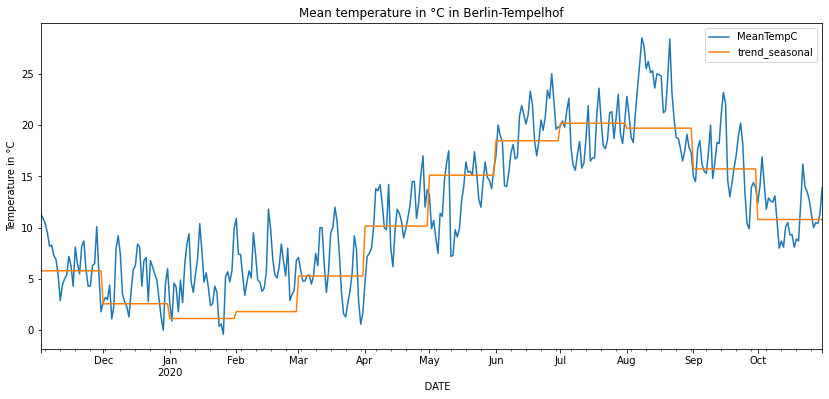

In [93]:
plot_temps(df_test[['MeanTempC', 'trend_seasonal']])

In [94]:
# Calculate the remainder for the test set
df7test = df_test.copy()
df7test['remainder'] = df_test['MeanTempC']-df_test['trend_seasonal']
df_test = df7test
df_test.head()

,MeanTempC,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder
DATE,,,,,,,,,,,,,,,,,
2019-11-02,11.3,11,2,26582,0,0,0,0,0,0,0,0,0,1,0,5.793207,5.506793
2019-11-03,10.9,11,3,26583,0,0,0,0,0,0,0,0,0,1,0,5.793266,5.106734
2019-11-04,10.4,11,4,26584,0,0,0,0,0,0,0,0,0,1,0,5.793324,4.606676
2019-11-05,9.5,11,5,26585,0,0,0,0,0,0,0,0,0,1,0,5.793382,3.706618
2019-11-06,8.2,11,6,26586,0,0,0,0,0,0,0,0,0,1,0,5.793441,2.406559


In [95]:
#save remainder of test data to file
df_test['remainder'].to_csv('data/temps_test_remainder.csv')

In [96]:
# Create the lagged variable
df8test = df_test.copy()
df8test['lag1'] = df_test['remainder'].shift(1)
df8test['lag2'] = df_test['remainder'].shift(2)
df8test['lag3'] = df_test['remainder'].shift(3)
df8test.dropna(inplace=True)
df_test = df8test
df_test.head()

,MeanTempC,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,,,
2019-11-05,9.5,11,5,26585,0,0,0,0,0,0,0,0,0,1,0,5.793382,3.706618,4.606676,5.106734,5.506793
2019-11-06,8.2,11,6,26586,0,0,0,0,0,0,0,0,0,1,0,5.793441,2.406559,3.706618,4.606676,5.106734
2019-11-07,8.3,11,7,26587,0,0,0,0,0,0,0,0,0,1,0,5.793499,2.506501,2.406559,3.706618,4.606676
2019-11-08,7.3,11,8,26588,0,0,0,0,0,0,0,0,0,1,0,5.793557,1.506443,2.506501,2.406559,3.706618
2019-11-09,6.9,11,9,26589,0,0,0,0,0,0,0,0,0,1,0,5.793615,1.106385,1.506443,2.506501,2.406559


In [97]:
# Assign X_full_test
X_full_test = df_test.drop(columns = ['MeanTempC', 'month', 'day', 'trend_seasonal','remainder'])
X_full_test.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,
2019-11-05,26585,0,0,0,0,0,0,0,0,0,1,0,4.606676,5.106734,5.506793
2019-11-06,26586,0,0,0,0,0,0,0,0,0,1,0,3.706618,4.606676,5.106734
2019-11-07,26587,0,0,0,0,0,0,0,0,0,1,0,2.406559,3.706618,4.606676
2019-11-08,26588,0,0,0,0,0,0,0,0,0,1,0,2.506501,2.406559,3.706618
2019-11-09,26589,0,0,0,0,0,0,0,0,0,1,0,1.506443,2.506501,2.406559


In [98]:
# Create the predictions
df9test = df_test.copy()
df9test['predictions_full_model'] = m_full.predict(X_full_test)
df9test['predictions_full_modeldt'] = mdt_full.predict(X_full_test)
df9test['predictions_full_modelrf'] = mrf_full.predict(X_full_test)
df_test = df9test

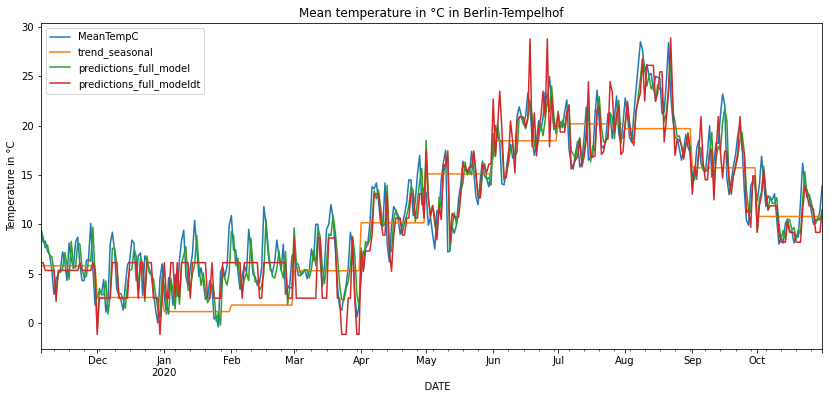

In [99]:
plot_temps(df_test[['MeanTempC','trend_seasonal', 'predictions_full_model', 'predictions_full_modeldt']])

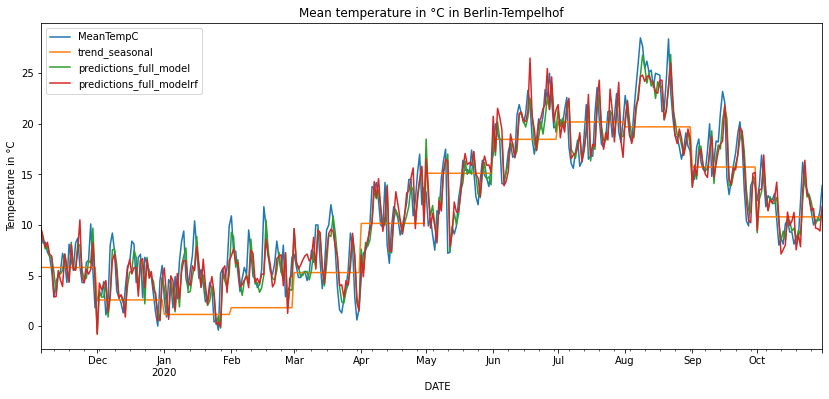

In [100]:
plot_temps(df_test[['MeanTempC','trend_seasonal', 'predictions_full_model', 'predictions_full_modelrf']])

In [101]:
df_train.head(3)

,MeanTempC,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,...,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full_model,predictions_full_modeldt,predictions_full_modelrf
DATE,,,,,,,,,,,,,,,,,,,,,
1947-01-25,-5.3,1,25,3,0,0,0,0,0,0,...,0,0,-0.405384,-4.894616,-4.094558,-3.394500,-2.394442,-3.649669,-1.157258,-5.204
1947-01-26,-8.7,1,26,4,0,0,0,0,0,0,...,0,0,-0.405325,-8.294675,-4.894616,-4.094558,-3.394500,-4.320907,-1.157258,-7.048
1947-01-27,-11.3,1,27,5,0,0,0,0,0,0,...,0,0,-0.405267,-10.894733,-8.294675,-4.894616,-4.094558,-7.355069,-4.742436,-9.993


In [102]:
# Create the complete dataset for model m_full and plot it
df_full = df_train[['MeanTempC','trend_seasonal', 'predictions_full_model']].append(df_test[['MeanTempC','trend_seasonal', 'predictions_full_model']])
df_full.head(3), df_full.tail(3)

(            MeanTempC  trend_seasonal  predictions_full_model
     DATE                                                     
 1947-01-25       -5.3       -0.405384               -3.649669
 1947-01-26       -8.7       -0.405325               -4.320907
 1947-01-27      -11.3       -0.405267               -7.355069,
             MeanTempC  trend_seasonal  predictions_full_model
     DATE                                                     
 2020-10-29       10.4       10.799148               10.708662
 2020-10-30       11.4       10.799207               10.418744
 2020-10-31       13.9       10.799265               11.401035)

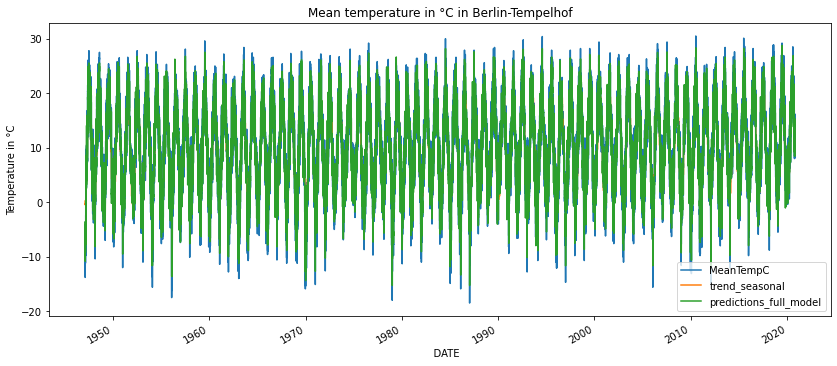

In [103]:
plot_temps(df_full)

In [107]:
# Create the complete dataset for model mdt_full and plot it
dft_full = df_train[['MeanTempC','trend_seasonal', 'predictions_full_modeldt']].append(df_test[['MeanTempC','trend_seasonal', 'predictions_full_modeldt']])
dft_full.head(3), dft_full.tail(3)

(            MeanTempC  trend_seasonal  predictions_full_modeldt
     DATE                                                       
 1947-01-25       -5.3       -0.405384                 -1.157258
 1947-01-26       -8.7       -0.405325                 -1.157258
 1947-01-27      -11.3       -0.405267                 -4.742436,
             MeanTempC  trend_seasonal  predictions_full_modeldt
     DATE                                                       
 2020-10-29       10.4       10.799148                  9.180103
 2020-10-30       11.4       10.799207                  9.180103
 2020-10-31       13.9       10.799265                 11.479688)

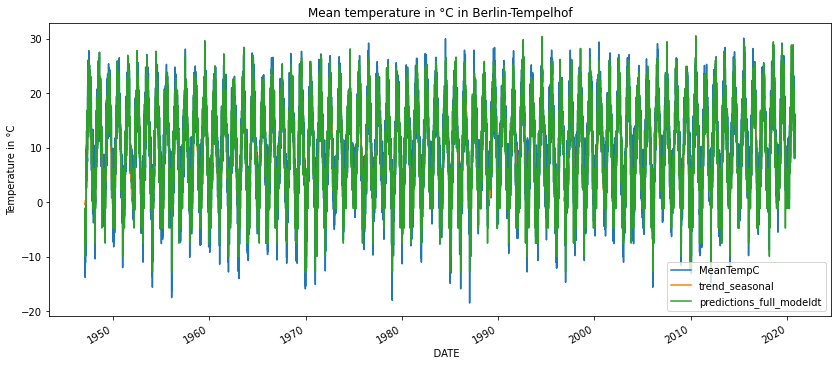

In [108]:
plot_temps(dft_full)

## Deploy and monitor

In [109]:
m_full.score(X_full_train, y_full_train)

0.9147566151368931

In [110]:
mdt_full.score(X_full_train, y_full_train)

0.8996265880020061

In [111]:
mrf_full.score(X_full_train, y_full_train)

0.986873366826758

In [112]:
y_full_test = df_test[['MeanTempC']]

In [113]:
m_full.score(X_full_test, y_full_test)

0.8964438334760273

In [114]:
mdt_full.score(X_full_test, y_full_test)

0.8449156293042281

In [115]:
mrf_full.score(X_full_test, y_full_test)

0.886019745825591

What now? Predict the future.

How? Train full model on entire data, # --> remainder cannot be included for prediction as this will be the future, lag 0 will be asserted after the first day of prediction (which is predicted using the last remainder accessible)